In [1]:
import sys; sys.path.append('../code')

import matplotlib.pyplot as plt
plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']

plt.rcParams['text.usetex'] = False
#plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["ps.usedistiller"] = 'xpdf'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams["mathtext.fontset"] = 'cm'

from plot_utility import mathify_ticklabels

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pynumdiff
import fly_plot_lib.plot as fpl
import figurefirst as fifi

In [3]:
import utility

In [4]:
fififig = '../figures_svg/fig_S1_anemotaxis_2d.svg'
FONTSIZE = 7

In [5]:
def plot_2_phase_portrait(ax_label, k_psi, k_phi, vel, plot_trajectories=True):
    
    layout = fifi.svg_to_axes.FigureLayout(fififig, 
                                       autogenlayers=True, make_mplfigures=True, hide_layers=[])
    ax = layout.axes[(ax_label, ax_label)]

    def f(Y, t):
        psi, psi_zeta, vel  = Y
        
        psi = utility.wrap_angle(psi)
        psi_zeta = utility.wrap_angle(psi_zeta)

        psi_dot = -k_psi*psi
        psi_zeta_dot = k_phi*np.arctan2(vel*np.sin(psi) - np.sin(psi-psi_zeta), vel*np.cos(psi) - np.cos(psi-psi_zeta)) - k_psi*psi

        return [psi_dot, psi_zeta_dot, 0]

    psi = np.linspace(-np.pi*2, np.pi*2, 20)
    psi_zeta = np.linspace(-np.pi*2, np.pi*2, 20)

    Y1, Y2 = np.meshgrid(psi, psi_zeta)

    t = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    for i in range(NI):
        for j in range(NJ):
            x = Y1[i, j]
            y = Y2[i, j]
            yprime = f([x, y, vel], t)
            u[i,j] = yprime[0]
            v[i,j] = yprime[1]

    Q = ax.quiver(Y2, Y1, v, u, color='black', scale=100)

    if plot_trajectories:
        y0s = [[2, 1, vel], [2, 4, vel], [-3, -5, vel], [1, -1, vel]]
        for y0 in y0s:
            tspan = np.linspace(0, 100, 1000000)
            result  = odeint(f, y0, tspan, full_output=True)
            ys = result[0]
            
            ys[:,0] = utility.wrap_angle(ys[:,0])
            
            #ax.plot(ys[:,1], ys[:,0], '.')
            ax.plot(ys[:,1], ys[:,0], 'b-', linewidth=0.5) # path
            ax.plot(ys[:,1]+4*np.pi, ys[:,0], 'b-', linewidth=0.5) # path
            ax.plot(ys[:,1]-4*np.pi, ys[:,0], 'b-', linewidth=0.5) # path
            
            ax.plot([ys[0,1]], [ys[0,0]], 'o', color='green') # start
            ax.plot([ys[-1,1]], [ys[-1,0]], 's', color='red') # end

            if 1:
                ix = np.unique( np.logspace(0.001, np.log10(len(tspan)-2), 20).astype(int) )

                d_psi_zeta = pynumdiff.finite_difference.first_order(ys[:,1], 1)[1]
                d_psi = pynumdiff.finite_difference.first_order(ys[:,0], 1)[1]
                slopes = np.arctan2(d_psi, d_psi_zeta)

                fpl.colorline_with_heading(ax, ys[ix,1], ys[ix,0], 'blue', slopes[ix], 
                                                   size_angle=40,
                                                    nskip=0, size_radius=.4, deg=False, 
                                                       center_point_size=0.0001, show_centers=False,
                                          center_offset_fraction=0.5)

                fpl.colorline_with_heading(ax, ys[ix,1]+4*np.pi, ys[ix,0], 'blue', slopes[ix], 
                                                   size_angle=40,
                                                    nskip=0, size_radius=.4, deg=False, 
                                                       center_point_size=0.0001, show_centers=False,
                                          center_offset_fraction=0.5)
                fpl.colorline_with_heading(ax, ys[ix,1]-4*np.pi, ys[ix,0], 'blue', slopes[ix], 
                                                   size_angle=40,
                                                    nskip=0, size_radius=.4, deg=False, 
                                                       center_point_size=0.0001, show_centers=False,
                                          center_offset_fraction=0.5)

    ax.set_xlim(-2*np.pi, 2*np.pi)
    ax.set_ylim(-1*np.pi, 1*np.pi)
            
    xticks = [-2*np.pi+0, -np.pi+0, 0, np.pi+0, 2*np.pi+0]
    yticks = [-np.pi+0, 0, np.pi+0]
    spines = ['left', 'bottom']
    fifi.mpl_functions.adjust_spines(ax, spines, 
                                 yticks=yticks,
                                 xticks=xticks,
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
            
    if ax_label == 'zeta_a':
        xticklabels = [r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$']
        ax.set_xticklabels(xticklabels, rotation = 0)
        yticklabels = [r'$-\pi$', r'$0$', r'$\pi$']
        ax.set_yticklabels(yticklabels)

        ax.set_ylabel(r'$\psi$' + '\n Course direction relative \n to head orientation')
        ax.set_xlabel(r'$\psi_{\zeta}=\phi+\psi-\zeta$' + '\n Course direction relative \n to ambient wind direction')

        ax.yaxis.set_label_coords(-.1, .4)
        fifi.mpl_functions.set_fontsize(ax, FONTSIZE)
        
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    layout.append_figure_to_layer(layout.figures[ax_label], ax_label, cleartarget=True)
    layout.write_svg(fififig)
    


In [6]:
vel = 2

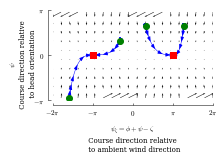

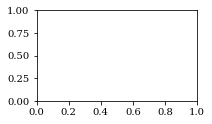

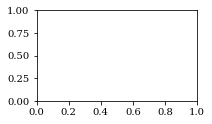

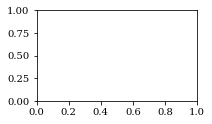

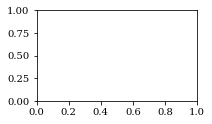

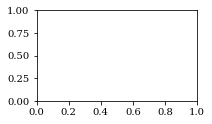

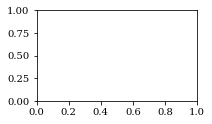

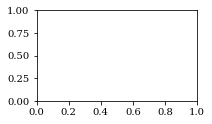

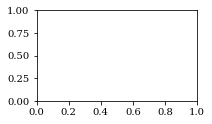

In [7]:
k_psi = 1
k_phi = 1
plot_2_phase_portrait('zeta_a', k_psi, k_phi, vel)

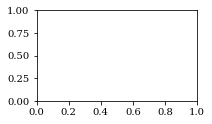

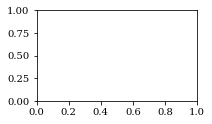

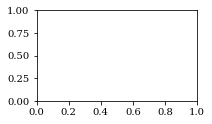

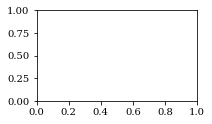

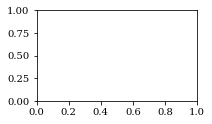

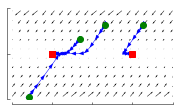

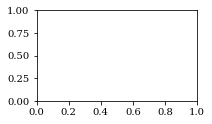

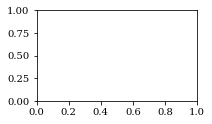

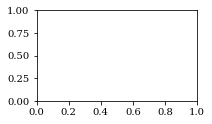

In [8]:
k_psi = 1
k_phi = .2
plot_2_phase_portrait('zeta_b', k_psi, k_phi, vel)

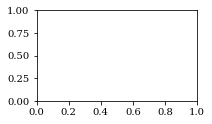

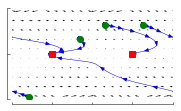

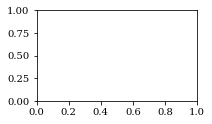

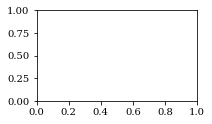

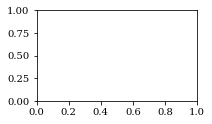

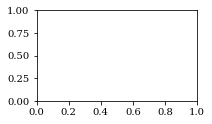

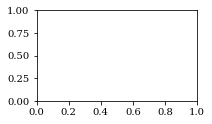

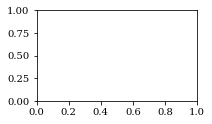

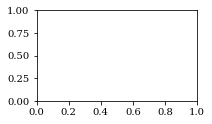

In [9]:
k_psi = .2
k_phi = 1
plot_2_phase_portrait('zeta_c', k_psi, k_phi, vel, plot_trajectories=True)

In [10]:
vel = 1

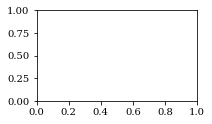

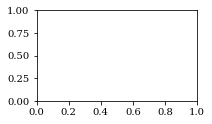

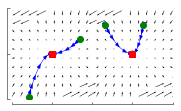

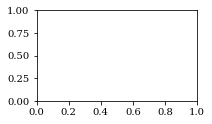

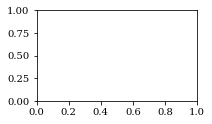

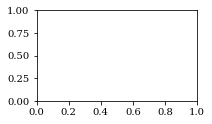

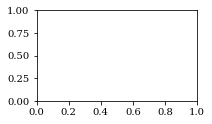

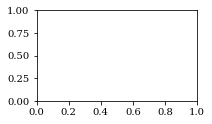

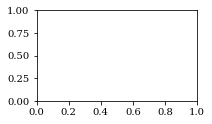

In [11]:
k_psi = 1
k_phi = 1
plot_2_phase_portrait('zeta_d', k_psi, k_phi, vel)

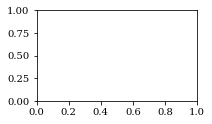

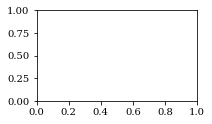

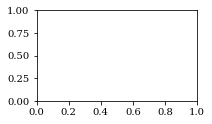

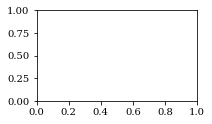

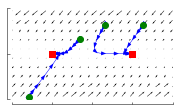

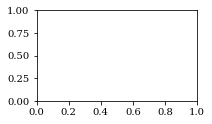

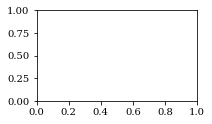

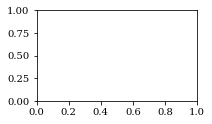

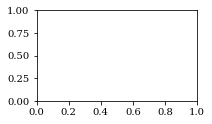

In [12]:
k_psi = 1
k_phi = .2
plot_2_phase_portrait('zeta_e', k_psi, k_phi, vel)

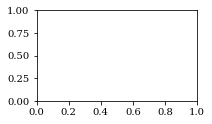

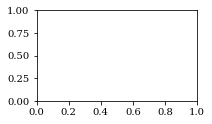

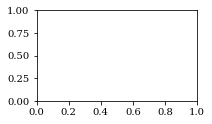

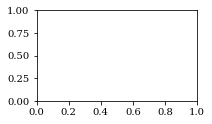

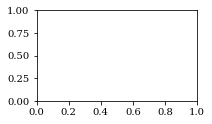

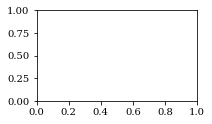

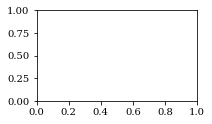

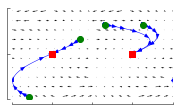

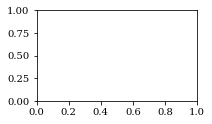

In [13]:
k_psi = .2
k_phi = 1
plot_2_phase_portrait('zeta_f', k_psi, k_phi, vel, plot_trajectories=True)

In [14]:
vel = 0.5

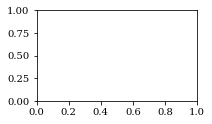

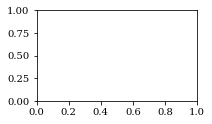

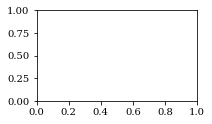

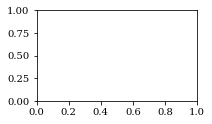

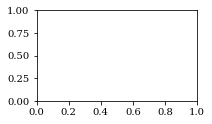

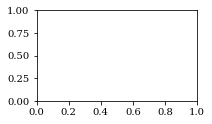

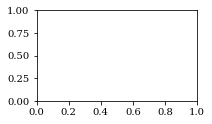

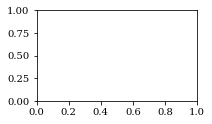

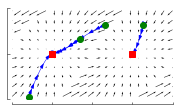

In [15]:
k_psi = 1
k_phi = 1
plot_2_phase_portrait('zeta_g', k_psi, k_phi, vel)

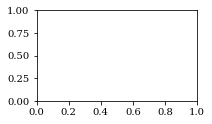

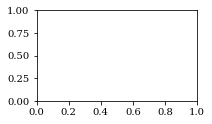

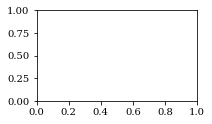

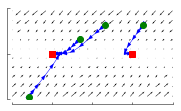

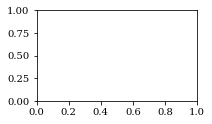

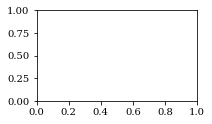

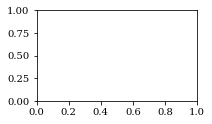

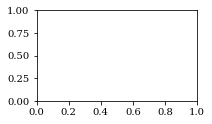

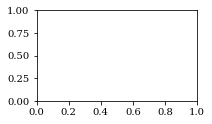

In [16]:
k_psi = 1
k_phi = .2
plot_2_phase_portrait('zeta_h', k_psi, k_phi, vel)

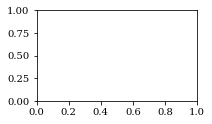

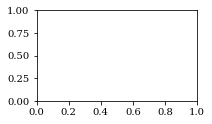

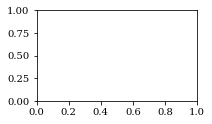

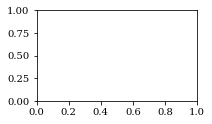

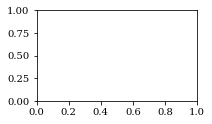

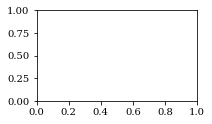

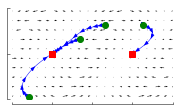

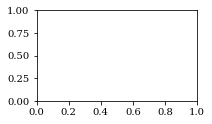

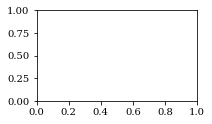

In [17]:
k_psi = .2
k_phi = 1
plot_2_phase_portrait('zeta_i', k_psi, k_phi, vel, plot_trajectories=True)

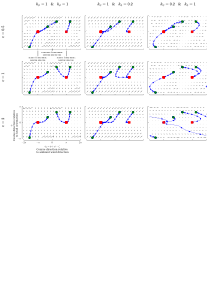

In [18]:
from IPython.display import display,SVG
display(SVG(fififig))